#### imports

In [73]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import pickle
## from SCRIPT.eval_tools import *
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from matplotlib import rcParams
import folium
import json
from urllib.request import urlopen
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

#### let's load some data! 🥒

In [39]:
with open('pickles/timeseries_sac_p.pkl', 'rb') as fp:
    sac_p = pickle.load(fp)

In [40]:
sac_p.index = pd.DatetimeIndex(sac_p.index.values, freq='infer')

In [41]:
sac_p.columns = sac_p.columns.astype(str)

In [42]:
trdf = sac_p.iloc[:-40]

In [43]:
select_zipcode = ['95630', '95608', '95818', '95632', '95824']

#### let's look at the range of data

In [44]:
trdf.describe().T.describe()[['mean', 'min', 'max']]

,mean,min,max
count,48.000000,48.000000,48.000000
mean,704.684871,-5.045066,162690.125000
std,208.387702,5.878197,48142.030432
min,399.710285,-40.434235,92194.000000
25%,553.628667,-4.262511,127799.750000
50%,679.192468,-3.796601,156790.000000
75%,823.787166,-3.363537,190210.000000
max,1352.863978,-2.526268,312427.000000


In [45]:
zip_1 = select_zipcode[0]
sel_df1 = sac_p[zip_1]
zip_2 = select_zipcode[1]
sel_df2 = sac_p[zip_2]
zip_3 = select_zipcode[2]
sel_df3 = sac_p[zip_3]
zip_4 = select_zipcode[3]
sel_df4 = sac_p[zip_4]
zip_5 = select_zipcode[4]
sel_df5 = sac_p[zip_5]

## baseline

#### evaluate the performance of each forecasting model, we need to measure the differences between predicted values and the actual or observed values. For the models below I used the commonly-used measurement metric root-mean-square error (RMSE) also referred to as root-mean-square deviation (RMSD)

* #### RSME = *root-mean-square deviation (RMSD) or root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSD represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences*

In [16]:
#persistence algorithm, which predicts the value to be the same as the last observed value.

In [46]:
def RMSE(y_true, y_pred):
    return sqrt(MSE(y_true, y_pred))

In [47]:
def get_RMSE(data, model, term = 40, show = True):
    pred = model.get_prediction(-term)
    pred_ci = pred.conf_int()
    sel_dat = data[-term:]
    rmse = RMSE(sel_dat, pred.predicted_mean)
    if show:
        ax = data.plot(label='observed', figsize=(8, 6))
        pred.predicted_mean.plot(ax=ax, label='predicted')
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=0.1)
        ax.set_xlabel('Date')
        ax.set_ylabel('Percent Increase')
        
        plt.legend(loc='best')
        plt.show()
    return rmse

In [48]:
baseline_RMSE = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    pred = df.shift()[-40:]
    y_test = df[-40:]
    baseline_RMSE.append(RMSE(y_test, pred))

In [49]:
results = pd.DataFrame(baseline_RMSE, columns = ['baseline'])

In [50]:
baseline_RMSE2 = list()
for df in [sel_df1, sel_df2, sel_df3, sel_df4, sel_df5]:
    y_train = [np.mean(df[:-40])] * 40
    y_test = df[-40:]
    baseline_RMSE2.append(RMSE(y_test, pred))

In [51]:
results['historic_avg'] = baseline_RMSE2

## SARIMA evaluation

### zip code 95630 
#### plot moving average and sd

In [52]:
def plot_moving_avg(series, window, zipcode = ''):
    rolling_mean = series.rolling(window = window).mean()
    rolling_sd = series.rolling(window = window).std()
    plt.figure(figsize = (10, 6))
    plt.plot(series, label = 'Actual Values', lw = 2)    
    plt.plot(rolling_mean, '--', label = 'Rolling Mean', lw = 2)
    plt.plot(rolling_sd, '--', label = 'Rolling St. Dev', lw = 2)
    plt.legend()
    plt.ylabel('Percent Increase')
    plt.title(f'{window} Months Rolling Trend ({zipcode})')
    plt.show()

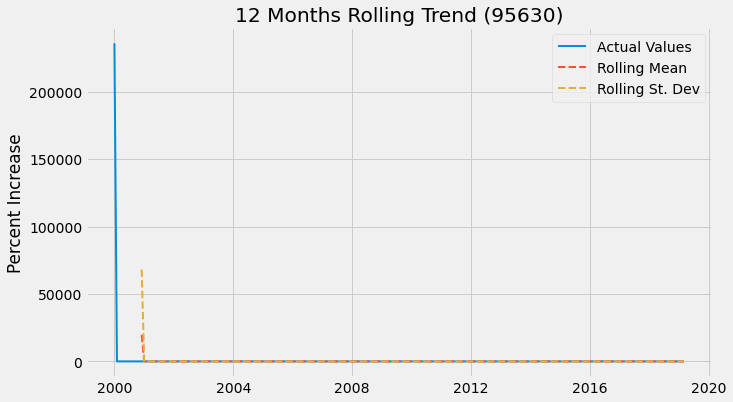

In [53]:
plot_moving_avg(sel_df1[:-40], 12, zip_1)

 ### stationarity or trend-stationarity?
 ### zipCode 95630 
* #### dickey_fuller tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. 

In [70]:
def run_dickey_fuller(series, title):
    result = adfuller(series)
    p = result[1]
    if p < 0.05:
        print(f'Null Rejected (p = {round(p, 4)}). {title} time series is stationary')
    else: 
        print(f'Failed to reject the null (p = {round(p, 4)}). {title} time series is not stationary')

In [71]:
run_dickey_fuller(sel_df1[:-40], zip_1)

Failed to reject the null (p = 0.1115). 95630 time series is not stationary


In [56]:
def plot_decomposition(series, zipcode = ''):
    rcParams['figure.figsize'] = 12,6
    seasonal_decompose(series).plot()
    plt.xlabel(f'year ({zipcode})')
    plt.show()

    

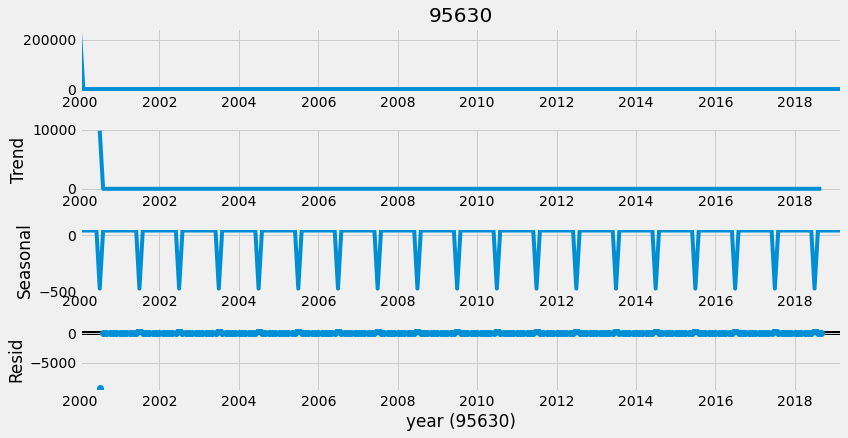

In [57]:
plot_decomposition(sel_df1[:-40], zip_1)

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


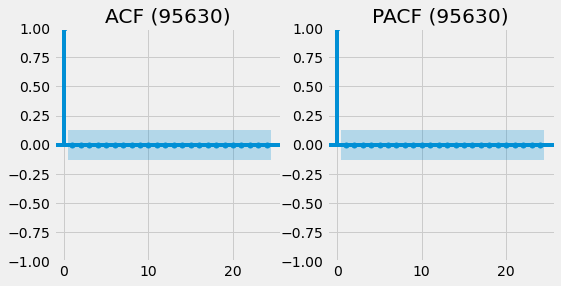

In [58]:
def def_acf_pacf(series, zipcode):
    plt.figure(figsize = (8, 4))
    ax1 = plt.subplot(1, 2, 1)
    plot_acf(series, ax = ax1, alpha = 0.05)
    plt.title(f'ACF ({zipcode})')
    ax2 = plt.subplot(1, 2, 2)
    plot_pacf(series, ax = ax2, alpha = 0.05)
    plt.title(f'PACF ({zipcode})')
    plt.show()


def_acf_pacf(sel_df1[:-40], zip_1)

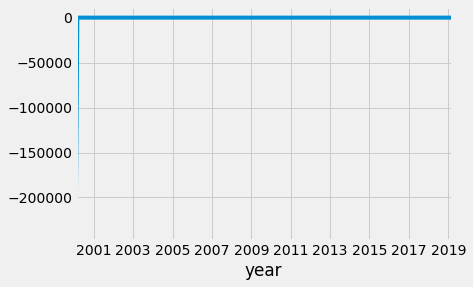

In [59]:
def plot_basic(series, xlabel = 'year', ylabel = '', title = ''):
    ''' return basic time series plot ''' 
    plt.figure(figsize = (6, 4))
    series.plot()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()



plot_basic(sel_df1[:-40].diff(1)[1:])

In [72]:
run_dickey_fuller(sel_df1[:-40].diff(1)[1:], zip_1)

Null Rejected (p = 0.0043). 95630 time series is stationary


In [61]:
def find_sarima_param(df, max_range = 2, 
                      p = range(0, 2), 
                      q = range(0, 2),
                      d = range(0, 2),
                      s = 12, thresh = 500):
    '''find the best sarima params'''
    
    pdq = list(product(p, d, q))
    spdq = [x + (s,) for x in pdq]
    min_param = [None, None, thresh]

    for param in pdq:
        for sparam in spdq:
            try:
                mod = SARIMAX(df, order=param,
                              seasonal_order=sparam)
                results = mod.fit()

                if results.aic < min_param[2]: 
                    min_param[0] = param
                    min_param[1] = sparam
                    min_param[2] = results.aic
            except:
                continue
    print(f'pdq: {min_param[0]}, PDQS: {min_param[1]} - AIC: {round(min_param[2], 2)}')
    return min_param[0], min_param[1]


In [62]:
pdq, SPDQ = find_sarima_param(sel_df1[:-40])

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


pdq: (0, 0, 1), PDQS: (1, 1, 0, 12) - AIC: 6.0


C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


## covariance matrix tests

In [34]:
sarima = SARIMAX(sel_df1[:-40], order=pdq, 
        seasonal_order=SPDQ, 
        enforce_stationarity=False, 
        enforce_invertibility=False)
sarima_model1 = sarima.fit()
print(sarima_model1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               95630   No. Observations:                  231
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -297.546
Date:                             Fri, 02 Sep 2022   AIC                            601.092
Time:                                     21:44:56   BIC                            611.090
Sample:                                 01-01-2000   HQIC                           605.135
                                      - 03-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8422      0.028     29.832      0.000       0.787       0.898
ar.S.L12       0.0007    4.


### so what's all the above saying? defining the matrix... free your mind!
* #### Ljung-Box (L1) (Q): is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the "overall" randomness based on a number of lags, and is therefore a portmanteau test.                 
* ####  Heteroskedasticity used in a linear regression model and assumes that the error terms are normally distributed. It tests whether the variance of the errors from a regression is dependent on the values of the independent variables.
* #### Jarque-Bera is a type of Lagrange multiplier test, is a test for normality.Specifically, the test matches the skewness and kurtosis of data to see if it matches a normal distribution.
* #### kurtosis is a measure that describes the shape of a distribution's tails in relation to its overall shape. apositive value tells you that you have heavy-tails (i.e. a lot of data in your tails
* #### skewness is the degree of asymmetry observed in a probability distribution.


In [119]:
# Warnings:⚠️[1] Covariance matrix calculated using the outer product of gradients (complex-step).
# more like a "note" than a "warning". It's just letting you know how the covariance matrix 
# was computed.

## sarima with plot_diagnostics
* #### plot_diagnostics( ), which function to ensure that none of the assumptions made by the model have been violated, and that there is no unusual behavior.

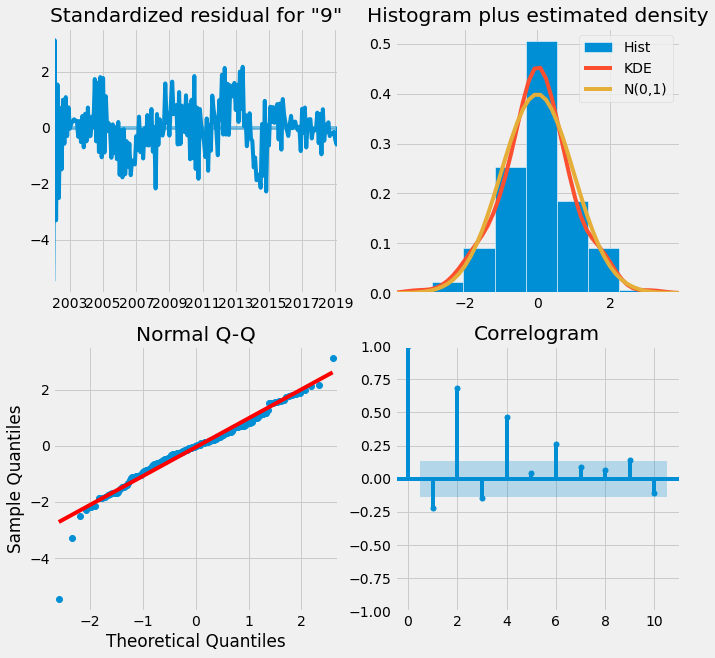

In [63]:
sarima_model1.plot_diagnostics(figsize = (10 ,10))
plt.show()

### explanation of plots (above)
* #### TOP LEFT plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.
* #### TOP RIGHT we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.
* #### BOTTOM LEFT qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).
* #### BOTTOM RIGHT The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

### Concusion of plot_diagnostics above
#### by validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

## rolling forcast

In [64]:
def rolling_forecast(df, pdq, SPDQ, term = 40):
    train = df[:-term]
    test = df[-term:]
    hist = list(train)
    pred = list()
    for term in range(len(test)):
        model = SARIMAX(hist, order = pdq, 
                        seasonal_order = SPDQ,enforce_stationarity=False) 
        fit = model.fit(disp=0)
        pred.append(fit.forecast()[0])
        hist.append(test[term]) 
    return train, test, hist, pred

In [65]:

def test_RMSE(df, pdq, SPDQ, term = 40, show = True):
    ''' get RMSE for test set '''
    _, test, _, pred = rolling_forecast(df, pdq, SPDQ, term = term)
    
    if show:
        plt.figure(figsize=(8, 6))
        plt.plot(df, label='true')
        plt.plot(test.index, pred, label='Forecast')
        plt.xlabel('Date')
        plt.ylabel('Percent Increase')        
        plt.legend(loc='best')
        plt.title('Rolling Forecasting On Test Set')
        plt.show()
    return RMSE(test, pred)

#### got; LinAlgError: LU decomposition error. ⚠️

#### so let's check for nans

In [66]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)


#### error solved!  🎈 needed to add param  "enforce_stationarity=False" . No one on earth knows why either.

In [69]:
# got; LinAlgError: LU decomposition error. ⚠️
#added-enforce_stationarity=False) 
#model = SARIMAX(hist, order = pdq, 
                       #
    #seasonal_order = SPDQ, enforce_stationarity=False)
    
# What did this parameter do exactly? ...even the guy that suggested fix didn't know

C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\qatester\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


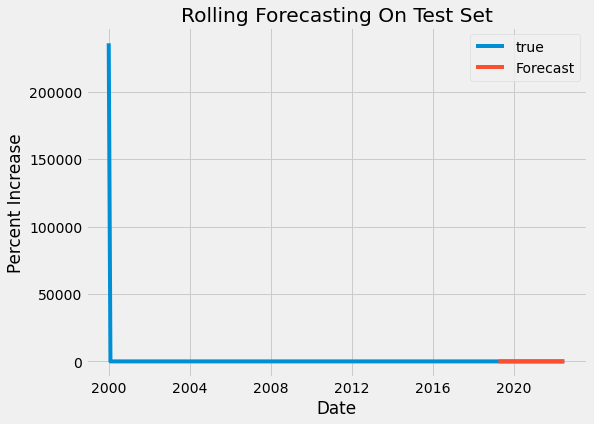

In [68]:
rmse_1 = test_RMSE(sel_df1, pdq, SPDQ)